# 01 Import libraries

In [162]:
import pandas as pd
import numpy as np 
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [163]:
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [164]:
# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)
%matplotlib inline

# 02 Import data 

In [165]:
path = r'/Users/woodoooo/Desktop/World University Rankings'

In [166]:
file = os.path.join(path, '02_Data', 'Prepared Data', 'QS_Rankings_selected_col_cleaned.xlsx')

In [167]:
df = pd.read_excel(file)

# 03 Explanatory Regression -- Multiple Linear Regression (OLS) & Quantile Regression

In [168]:
df.columns

Index(['Rank_num', 'Rank_sym', 'Previous Rank_num', 'Previous Rank_sym', 'Name', 'Country/Territory', 'Region', 'Size', 'Focus', 'Research', 'Status', 'AR SCORE', 'ER SCORE', 'FSR SCORE',
       'CPF SCORE', 'IFR SCORE', 'ISR SCORE', 'ISD SCORE', 'IRN SCORE', 'EO SCORE', 'SUS SCORE', 'AR RANK_num', 'AR RANK_sym', 'ER RANK_num', 'ER RANK_sym', 'FSR RANK_num', 'FSR RANK_sym',
       'CPF RANK_num', 'CPF RANK_sym', 'IFR RANK_num', 'IFR RANK_sym', 'ISR RANK_num', 'ISR RANK_sym', 'ISD RANK_num', 'ISD RANK_sym', 'IRN RANK_num', 'IRN RANK_sym', 'EO RANK_num', 'EO RANK_sym',
       'SUS RANK_num', 'SUS RANK_sym', 'Overall SCORE'],
      dtype='object')

Goal: understand relationships between variables.
Focus: Why does 𝑌 change when 𝑋 changes?
The focus is on coefficients (effect sizes, significance, standardized betas), not on predicting unseen universities.
Question is: Does Academic Reputation or Employer Reputation or SUS score matter more for Overall Score?

In [169]:
# 1) Prepare data (rename + clean)

# Keep only the columns we need and drop rows with missing values
df_qr = (
    df[['Overall SCORE', 'AR SCORE', 'ER SCORE', 'SUS SCORE']].copy()
      .rename(columns={'Overall SCORE':'overall', 'AR SCORE':'ar', 'ER SCORE':'er', 'SUS SCORE':'ss'})
      .dropna()
)

In [170]:
print(df_qr.describe())

          overall          ar          er          ss
count  703.000000  703.000000  703.000000  703.000000
mean    46.729872   42.125605   43.043812   66.148933
std     18.861123   27.096539   28.160694   17.594515
min     25.100000    3.100000    2.000000   12.500000
25%     30.900000   20.850000   19.350000   53.400000
50%     41.500000   33.900000   37.300000   67.400000
75%     58.900000   59.700000   62.650000   79.700000
max    100.000000  100.000000  100.000000  100.000000


In [171]:
# Correlation matrix for 3 scores
corr_matrix = df_qr[['ar', 'er', 'ss']].corr(method='pearson')

print("Correlation matrix (ar, er, ss):")
print(corr_matrix)

Correlation matrix (ar, er, ss):
          ar        er        ss
ar  1.000000  0.808735  0.635664
er  0.808735  1.000000  0.456030
ss  0.635664  0.456030  1.000000


In [172]:
# Build design matrix for VIF (include all 3 predictors)
X = sm.add_constant(df_qr[['ar', 'er', 'ss']])

# 2) Compute VIF for each column
vif = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print(vif)

  feature        VIF
0   const  17.189142
1      ar   3.905685
2      er   2.938651
3      ss   1.705933


ar (3.9) → Some correlation with the other predictors, but still acceptable (below 5).

er (2.9) → Even lower, no serious multicollinearity problem.

ss (1.7) → Very low, almost independent from the others.

In [173]:
# Predictors: AR, ER, SS
X = sm.add_constant(df_qr[['ar','er','ss']])
y = df_qr['overall']

# OLS with robust (HC3) standard errors
ols = sm.OLS(y, X).fit(cov_type='HC3')

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     1162.
Date:                Tue, 09 Sep 2025   Prob (F-statistic):          4.36e-271
Time:                        13:17:07   Log-Likelihood:                -2403.8
No. Observations:                 703   AIC:                             4816.
Df Residuals:                     699   BIC:                             4834.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9479      1.132      8.785      0.0

In [174]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Helper to fit quantile regression across a list of quantiles
def run_quantile_regression(df_in, formula, quantiles):
    mod = smf.quantreg(formula, df_in)
    rows = []
    for q in quantiles:
        res = mod.fit(q=q)
        rows.append({
            'quantile': q,
            'Intercept': res.params.get('Intercept', np.nan),
            
            # AR
            'ar_coef': res.params.get('ar', np.nan) if 'ar' in res.params else res.params.get('ar_z', np.nan),
            'ar_p': res.pvalues.get('ar', np.nan) if 'ar' in res.pvalues else res.pvalues.get('ar_z', np.nan),
            
            # ER
            'er_coef': res.params.get('er', np.nan) if 'er' in res.params else res.params.get('er_z', np.nan),
            'er_p': res.pvalues.get('er', np.nan) if 'er' in res.pvalues else res.pvalues.get('er_z', np.nan),
            
            # SS
            'ss_coef': res.params.get('ss', np.nan) if 'ss' in res.params else res.params.get('ss_z', np.nan),
            'ss_p': res.pvalues.get('ss', np.nan) if 'ss' in res.pvalues else res.pvalues.get('ss_z', np.nan),
        })
    return pd.DataFrame(rows)

# Quantiles to test
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]

# (a) Original scale
qr_table_raw = run_quantile_regression(df_qr, 'overall ~ ar + er + ss', quantiles)
print("Quantile regression (original scale):")
print(qr_table_raw)

Quantile regression (original scale):
   quantile  Intercept   ar_coef          ar_p   er_coef          er_p   ss_coef          ss_p
0      0.10  -0.883997  0.309280  2.486191e-18  0.146781  9.790282e-07  0.280427  5.276378e-29
1      0.25   2.849170  0.410537  7.760408e-34  0.122603  1.178625e-05  0.245186  2.270069e-18
2      0.50  10.140886  0.471497  4.288508e-60  0.112559  3.157356e-07  0.178828  3.593049e-11
3      0.75  18.354671  0.506203  3.127586e-69  0.112882  3.081595e-08  0.111835  1.897013e-04
4      0.90  21.295943  0.518844  1.954159e-75  0.124313  2.314062e-10  0.115681  7.356104e-05


In [175]:
def zscore(s):
    return (s - s.mean()) / s.std(ddof=0)

df_std = df_qr.copy()
for col in ['overall', 'ar', 'er', 'ss']:
    df_std[f'{col}_z'] = zscore(df_std[col])

In [176]:
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]

# Standardized scale
qr_table_std = run_quantile_regression(df_std, 'overall_z ~ ar_z + er_z + ss_z', quantiles)

print("\nQuantile regression (standardized scale):")
print(qr_table_std)


Quantile regression (standardized scale):
   quantile  Intercept   ar_coef          ar_p   er_coef          er_p   ss_coef          ss_p
0      0.10  -0.515569  0.444322  2.485666e-18  0.219153  9.789155e-07  0.261596  5.272863e-29
1      0.25  -0.270087  0.589792  7.758084e-34  0.183052  1.178707e-05  0.228720  2.270356e-18
2      0.50  -0.002788  0.677366  4.298916e-60  0.168070  3.151517e-07  0.166807  3.604975e-11
3      0.75   0.276187  0.727227  3.128487e-69  0.168540  3.080572e-08  0.104327  1.896476e-04
4      0.90   0.500103  0.745390  1.951681e-75  0.185607  2.313238e-10  0.107912  7.356963e-05


In [177]:
# Decide “who is stronger” at each quantile
# Use standardized coefficients so the comparison is fair.

def winner(row):
    # take absolute values of standardized coefficients
    a, e, s = abs(row['ar_coef']), abs(row['er_coef']), abs(row['ss_coef'])
    
    # handle missing values
    if np.isnan(a) or np.isnan(e) or np.isnan(s):
        return np.nan
    
    # find the maximum
    max_val = max(a, e, s)
    winners = []
    if a == max_val:
        winners.append('AR')
    if e == max_val:
        winners.append('ER')
    if s == max_val:
        winners.append('SS')
    
    # return string
    return ', '.join(winners) + " stronger"

# Apply function to each row
qr_table_std['stronger_predictor'] = qr_table_std.apply(winner, axis=1)

# Show results
print(qr_table_std[['quantile','ar_coef','er_coef','ss_coef',
                    'ar_p','er_p','ss_p','stronger_predictor']])


   quantile   ar_coef   er_coef   ss_coef          ar_p          er_p          ss_p stronger_predictor
0      0.10  0.444322  0.219153  0.261596  2.485666e-18  9.789155e-07  5.272863e-29        AR stronger
1      0.25  0.589792  0.183052  0.228720  7.758084e-34  1.178707e-05  2.270356e-18        AR stronger
2      0.50  0.677366  0.168070  0.166807  4.298916e-60  3.151517e-07  3.604975e-11        AR stronger
3      0.75  0.727227  0.168540  0.104327  3.128487e-69  3.080572e-08  1.896476e-04        AR stronger
4      0.90  0.745390  0.185607  0.107912  1.951681e-75  2.313238e-10  7.356963e-05        AR stronger


In [178]:
# 6) Decide “who is stronger” at each quantile
# Use standardized coefficients so the comparison is fair.

def winner(row):
    a, e = abs(row['ar_coef']), abs(row['er_coef'])
    if np.isnan(a) or np.isnan(e):
        return np.nan
    if a > e:
        return 'AR stronger'
    elif e > a:
        return 'ER stronger'
    else:
        return 'Tie'

qr_table_std['stronger_predictor'] = qr_table_std.apply(winner, axis=1)
print(qr_table_std[['quantile','ar_coef','er_coef','ar_p','er_p','stronger_predictor']])

   quantile   ar_coef   er_coef          ar_p          er_p stronger_predictor
0      0.10  0.444322  0.219153  2.485666e-18  9.789155e-07        AR stronger
1      0.25  0.589792  0.183052  7.758084e-34  1.178707e-05        AR stronger
2      0.50  0.677366  0.168070  4.298916e-60  3.151517e-07        AR stronger
3      0.75  0.727227  0.168540  3.128487e-69  3.080572e-08        AR stronger
4      0.90  0.745390  0.185607  1.951681e-75  2.313238e-10        AR stronger


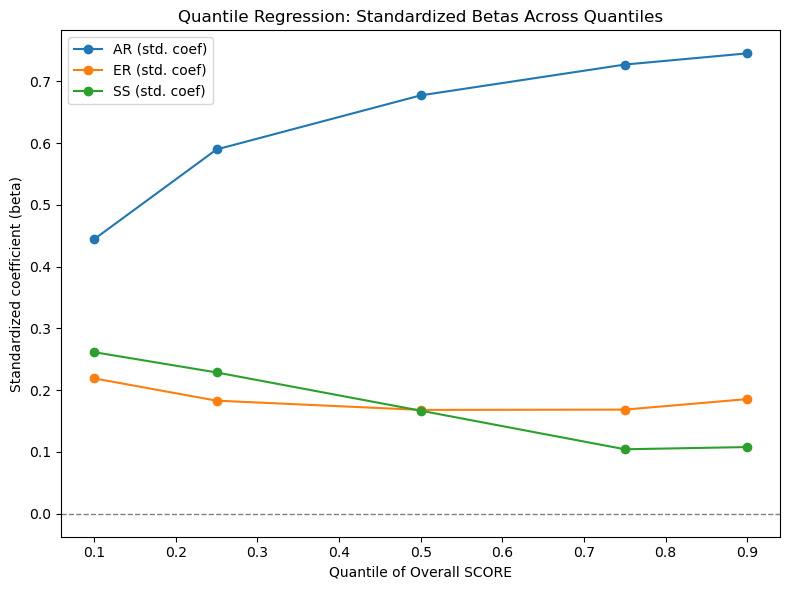

In [179]:
# Visualize coefficient paths across quantiles
plt.figure(figsize=(8,6))

# Plot standardized coefficients for each predictor
plt.plot(qr_table_std['quantile'], qr_table_std['ar_coef'], marker='o', label='AR (std. coef)')
plt.plot(qr_table_std['quantile'], qr_table_std['er_coef'], marker='o', label='ER (std. coef)')
plt.plot(qr_table_std['quantile'], qr_table_std['ss_coef'], marker='o', label='SS (std. coef)')

# Add baseline
plt.axhline(0, linestyle='--', color='gray', linewidth=1)

# Labels and title
plt.xlabel('Quantile of Overall SCORE')
plt.ylabel('Standardized coefficient (beta)')
plt.title('Quantile Regression: Standardized Betas Across Quantiles')

# Legend and layout
plt.legend()
plt.tight_layout()
out_dir = os.path.join(path, '04 Analysis', 'Visualisation')
out_file = os.path.join(out_dir, "quantile_regression_betas.png")
plt.savefig(out_file, dpi=300)

plt.show()

# 04 Prep for regression analysis 

Main Hypothesis

H₀ (null hypothesis): Academic Reputation (AR) has no significant effect on universities’ Overall Score.

H₁ (alternative hypothesis): Academic Reputation (AR) significantly predicts universities’ Overall Score.

In [180]:
df.shape

(1503, 42)

In [181]:
# Are there NaNs?
df[['AR SCORE', 'Overall SCORE']].isna().sum()

AR SCORE           0
Overall SCORE    798
dtype: int64

In [182]:
# Keep only rows with Overall SCORE present
df_score = df.dropna(subset=['Overall SCORE']).copy()

In [183]:
# Quick check
print(df_score.shape)         # how many rows left
print(df_score['Overall SCORE'].isna().sum())  # should be 0 now

(705, 42)
0


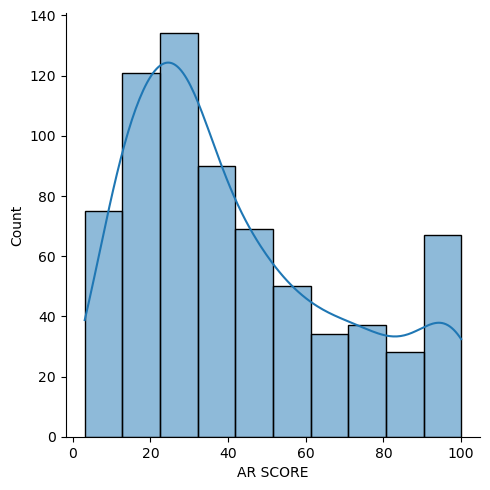

In [184]:
sns.displot(df_score['AR SCORE'], bins=10, kde=True)

out_dir = os.path.join(path, '04 Analysis', 'Visualisation')
out_file = os.path.join(out_dir, "How Academic Reputation (AR) is distributed among the top 705 universities.png")
plt.savefig(out_file, dpi=300)
plt.show()

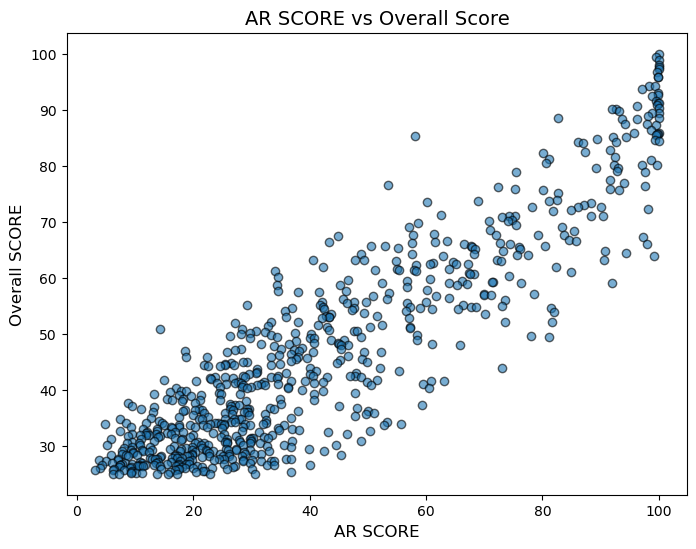

In [185]:
# Scatterplot: AR SCORE vs Overall Score
plt.figure(figsize=(8,6))  # set the figure size

plt.scatter(df_score['AR SCORE'], df_score['Overall SCORE'], alpha=0.6, edgecolor='k')

# Titles and labels
plt.title('AR SCORE vs Overall Score', fontsize=14)
plt.xlabel('AR SCORE', fontsize=12)
plt.ylabel('Overall SCORE', fontsize=12)

out_dir = os.path.join(path, '04 Analysis', 'Visualisation')
out_file = os.path.join(out_dir, "AR SCORE vs Overall Score.png")
plt.savefig(out_file, dpi=300)

plt.show()

In [186]:
# using a pandas DataFrame ([['AR SCORE']]) for X and a Series without reshape.
X = df_score[['AR SCORE']]
y = df_score['Overall SCORE']

In [187]:
X

,AR SCORE
0,100.0
1,99.6
2,100.0
3,100.0
4,100.0
...,...
700,22.8
701,15.7
702,13.8
703,7.2


In [188]:
y

0      100.0
1       99.4
2       98.9
3       97.9
4       97.7
       ...  
700     25.1
701     25.1
702     25.1
703     25.1
704     25.1
Name: Overall SCORE, Length: 705, dtype: float64

In [189]:
# Split data into a training set and a test set. Test split (70/30)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 04. Regression analysis

In [190]:
# Train regression model
model = LinearRegression() # This is the regression object, which will be fit onto the training set.
model.fit(X_train, y_train)

LinearRegression()

In [191]:
# Validate on test set
y_pred = model.predict(X_test)

In [192]:
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  


print("Validation results on 30% test set:")
print("R²:",  r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", rmse)

Validation results on 30% test set:
R²: 0.8039565280913308
MAE: 6.5736637218007505
RMSE: 8.300261649240532


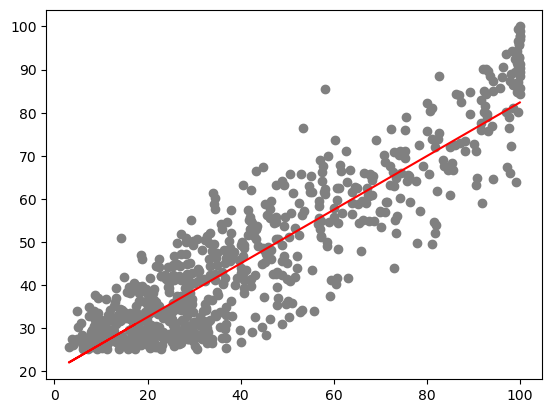

In [193]:
plt.scatter(X, y, color='gray')
plt.plot(X, model.predict(X), color='red')
plt.show()

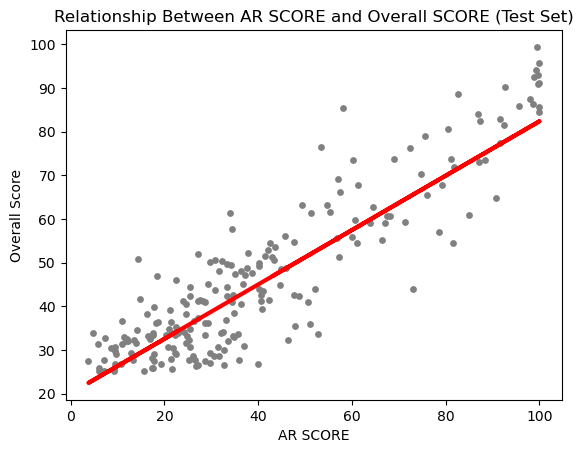

In [194]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_pred, color='red', linewidth =3)
plot_test.title('Relationship Between AR SCORE and Overall SCORE (Test Set)')
plot_test.xlabel('AR SCORE')
plot_test.ylabel('Overall Score')
plot_test.show()

In [195]:
# Refit on all 705 rows (use full info) 
model_final = LinearRegression()
model_final.fit(X, y)

LinearRegression()

In [196]:
# Predict missing Overall for the other 798 rows ---
df_missing = df[df['Overall SCORE'].isna()].copy()
df_missing['Predicted Overall'] = model_final.predict(df_missing[['AR SCORE']])

print("\nPredictions for missing Overall scores (first 10):")
print(df_missing[['AR SCORE','Predicted Overall']].head(10))


Predictions for missing Overall scores (first 10):
     AR SCORE  Predicted Overall
705      19.9          32.720570
706      37.4          43.745830
707      16.0          30.263512
708       7.0          24.593379
709      10.2          26.609426
710      15.9          30.200511
711      18.6          31.901551
712      23.2          34.799619
713       9.0          25.853408
714      20.8          33.287583


In [197]:
y_pred = model.predict(X_test)

In [198]:
y_pred

array([34.12238648, 33.18859543, 26.0295307 , 37.3595288 , 29.88920038,
       36.67474869, 52.54919658, 29.39117849, 56.28436079, 31.07200238,
       30.88524417, 36.79925417, 25.96727796, 40.97018753, 81.6834774 ,
       37.91980343, 70.29122657, 51.86441647, 23.72617944, 82.30600477,
       71.03825941, 37.91980343, 74.33765446, 38.41782532, 33.68661733,
       70.60249025, 39.7251328 , 62.13611805, 27.2123327 , 33.06408996,
       81.06095004, 70.8515012 , 46.3239229 , 35.49194669, 33.37535364,
       82.11924656, 37.04826511, 35.86546311, 26.0295307 , 45.07886816,
       35.42969396, 30.63623322, 24.53546502, 42.71326416, 40.47216564,
       42.52650595, 46.44842837, 45.70139553, 55.91084437, 30.32496954,
       69.48194099, 48.00474679, 54.23002047, 39.35161638, 28.08387101,
       47.94249405, 71.5362813 , 47.25771395, 55.72408616, 40.9079348 ,
       36.36348501, 31.07200238, 42.96227511, 33.43760638, 31.00974964,
       35.18068301, 45.01661542, 23.10365207, 36.98601238, 41.84

In [199]:
data = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred  
})
print("\nActual vs Predicted (first 30 on test):")
print(data.head(30))


Actual vs Predicted (first 30 on test):
    Actual  Predicted
0     35.2  34.122386
1     34.9  33.188595
2     29.9  26.029531
3     41.5  37.359529
4     25.1  29.889200
5     27.8  36.674749
6     44.0  52.549197
7     41.8  29.391178
8     85.4  56.284361
9     25.9  31.072002
10    28.3  30.885244
11    26.3  36.799254
12    30.8  25.967278
13    32.0  40.970188
14    92.5  81.683477
15    33.5  37.919803
16    80.5  70.291227
17    35.9  51.864416
18    31.3  23.726179
19    95.8  82.306005
20    72.0  71.038259
21    27.5  37.919803
22    73.0  74.337654
23    36.1  38.417825
24    30.5  33.686617
25    73.8  70.602490
26    30.6  39.725133
27    60.7  62.136118
28    33.0  27.212333
29    30.7  33.064090


In [200]:
# Predictions from the trained model on the test set
y_pred = model.predict(X_test)

# Create DataFrame with actual vs predicted values
data = pd.DataFrame({
    'Actual': y_test.values,         # true Overall scores
    'Predicted': y_pred.flatten()    # model predictions
})

# Show first 30 rows
print(data.head(30))

    Actual  Predicted
0     35.2  34.122386
1     34.9  33.188595
2     29.9  26.029531
3     41.5  37.359529
4     25.1  29.889200
5     27.8  36.674749
6     44.0  52.549197
7     41.8  29.391178
8     85.4  56.284361
9     25.9  31.072002
10    28.3  30.885244
11    26.3  36.799254
12    30.8  25.967278
13    32.0  40.970188
14    92.5  81.683477
15    33.5  37.919803
16    80.5  70.291227
17    35.9  51.864416
18    31.3  23.726179
19    95.8  82.306005
20    72.0  71.038259
21    27.5  37.919803
22    73.0  74.337654
23    36.1  38.417825
24    30.5  33.686617
25    73.8  70.602490
26    30.6  39.725133
27    60.7  62.136118
28    33.0  27.212333
29    30.7  33.064090


In [201]:
# --- Train/Test model ---
print("Train/Test model coefficients:")
print("Intercept:", model.intercept_)
print("Slope (AR → Overall):", model.coef_)

# Predictions on test set
y_pred_test = model.predict(X_test)

# Metrics on test set
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\nValidation metrics (30% test set):")
print("R²:", r2_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)

# --- Final model (all 705 rows) ---
print("\nFinal model coefficients:")
print("Intercept:", model_final.intercept_)
print("Slope (AR → Overall):", model_final.coef_)

# Predictions on all 705 rows
y_pred_final = model_final.predict(X)

# Metrics on all data
r2_final = r2_score(y, y_pred_final)
mae_final = mean_absolute_error(y, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y, y_pred_final))

print("\nMetrics on full dataset (705 rows):")
print("R²:", r2_final)
print("MAE:", mae_final)
print("RMSE:", rmse_final)


Train/Test model coefficients:
Intercept: 20.115520702300667
Slope (AR → Overall): [0.62252737]

Validation metrics (30% test set):
R²: 0.8039565280913308
MAE: 6.5736637218007505
RMSE: 8.300261649240532

Final model coefficients:
Intercept: 20.18327470102191
Slope (AR → Overall): [0.63001484]

Metrics on full dataset (705 rows):
R²: 0.8189619898125536
MAE: 6.334699254675865
RMSE: 8.01093965201805


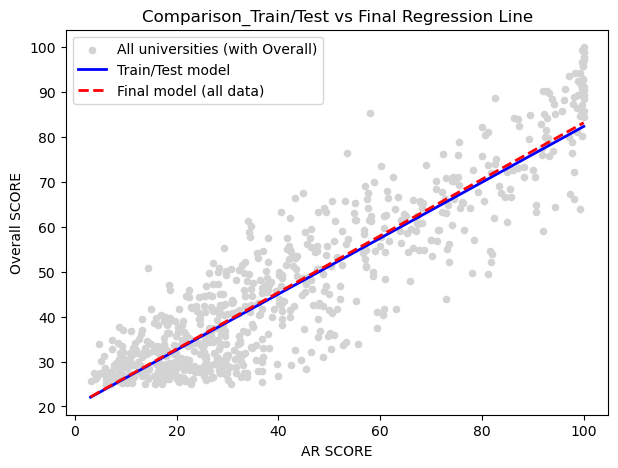

In [202]:
# Range of  AR SCORE (min → max), 100 points
x_range = np.linspace(X['AR SCORE'].min(), X['AR SCORE'].max(), 100)
x_range_df = pd.DataFrame(x_range, columns=['AR SCORE'])

# Regression line from the train/test model
y_train_line = model.predict(x_range_df)

# Regression line from the final model (all 705 rows)
y_final_line = model_final.predict(x_range_df)

plt.figure(figsize=(7,5))

# Scatter: all universities
plt.scatter(X['AR SCORE'], y, color='lightgray', s=20, label='All universities (with Overall)')

# Blue line: train/test model
plt.plot(x_range_df['AR SCORE'], y_train_line, color='blue', linewidth=2, label='Train/Test model')

# Red dashed line : final model 
plt.plot(x_range_df['AR SCORE'], y_final_line, color='red', linestyle='--', linewidth=2, label='Final model (all data)')

plt.xlabel("AR SCORE")
plt.ylabel("Overall SCORE")
plt.title("Comparison_Train/Test vs Final Regression Line")
plt.legend()

# --- Safe save path ---
out_dir = os.path.join(path, '04 Analysis', 'Visualisation')
os.makedirs(out_dir, exist_ok=True)  # <-- create folder if missing

fname = "Comparison_Train-Test_vs_Final_Regression_Line.png"
out_file = os.path.join(out_dir, fname)

plt.savefig(out_file, dpi=300)
plt.show()

# Quantile Regression

Extended Hypothesis (distributional/quantile angle)

H₀ (null hypothesis): The effect of Academic Reputation (AR) on Overall Score is uniform across the entire distribution of universities (low-ranked, mid-ranked, high-ranked).

H₁ (alternative hypothesis): The effect of Academic Reputation (AR) on Overall Score varies across quantiles — 
AR matters less for lower-ranked universities but becomes a stronger driver of Overall Score for mid- and top-ranked universities.

In [203]:
# 1) Prepare data (AR → Overall)
df_qr = (
    df[['Overall SCORE', 'AR SCORE']].copy()
      .rename(columns={'Overall SCORE':'overall', 'AR SCORE':'ar'})
      .dropna()
)

In [204]:
# Train/test split (25% test)
train, test = train_test_split(df_qr, test_size=0.3, random_state=42)

In [205]:
# 2) Standardize (train stats only → no leakage)
mean_ar,  std_ar  = train['ar'].mean(),  train['ar'].std(ddof=0)
mean_y,   std_y   = train['overall'].mean(), train['overall'].std(ddof=0)

train['ar_z']      = (train['ar'] - mean_ar) / std_ar
test['ar_z']       = (test['ar']  - mean_ar) / std_ar
train['overall_z'] = (train['overall'] - mean_y) / std_y
test['overall_z']  = (test['overall']  - mean_y) / std_y

In [206]:
# 3) Fit Quantile Regression (train) + evaluate (test)
def fit_qr_ar(train_df, test_df, formula, quantiles):
    mod = smf.quantreg(formula, train_df)  # e.g., 'overall_z ~ ar_z'
    rows = []
    for q in quantiles:
        res = mod.fit(q=q)

        # Predict on test and compute quantile (pinball) loss
        y_pred = res.predict(test_df)
        y_true = test_df[formula.split('~')[0].strip()]
        qloss  = mean_pinball_loss(y_true, y_pred, alpha=q)

        # pull AR coefficient/p-value (works for ar_z or ar)
        ar_name = [c for c in res.params.index if 'ar' in c][0]

        rows.append({
            'quantile': q,
            'Intercept': res.params.get('Intercept', np.nan),
            'ar_coef': res.params[ar_name],
            'ar_p': res.pvalues[ar_name],
            'test_pinball_loss': qloss
        })
    return pd.DataFrame(rows)

quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]

# Run standardized (best for comparing effect size)
qr_ar_std = fit_qr_ar(train, test, 'overall_z ~ ar_z', quantiles)
print(qr_ar_std)

   quantile  Intercept   ar_coef           ar_p  test_pinball_loss
0      0.10  -0.575931  0.710158  6.713336e-150           0.076608
1      0.25  -0.288988  0.802615  3.322297e-128           0.137989
2      0.50   0.023848  0.913063  2.819374e-145           0.167013
3      0.75   0.302807  0.957078  5.732185e-143           0.127478
4      0.90   0.513335  0.975516  1.020916e-143           0.070375


ar_coef → standardized coefficient: effect size of AR on Overall.
At the 0.10 quantile, 1 SD increase in AR increases Overall by 0.71 SD.
At the 0.90 quantile, the effect is even stronger (0.98 SD).
ar_p → p-value. All values are extremely small → AR is highly significant at all quantiles.

test_pinball_loss → out-of-sample quantile loss. Lower = better.
Shows how well the model predicts at each quantile on the test set.

Effect strength grows with quantile:
At the low end (10th percentile), AR matters (0.71).
By the median: effect is stronger (0.91).
At the top (90th percentile), AR dominates (0.98).
AR is significant everywhere → but it becomes more important the higher you go.
Pinball loss is lowest at the extremes (0.10, 0.90) → the model fits tails slightly better than the middle.

Quantile regression confirms that Academic Reputation (AR) is the decisive driver across the entire distribution.
Its impact is strongest for top universities, where AR nearly explains the Overall Score one-to-one (0.98).

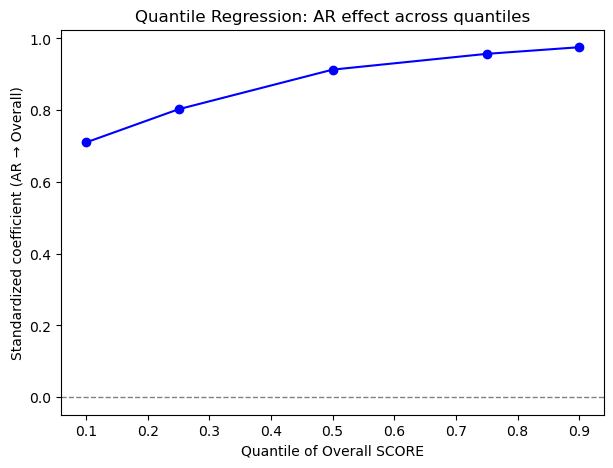

In [207]:
plt.figure(figsize=(7,5))
plt.plot(qr_ar_std['quantile'], qr_ar_std['ar_coef'], marker='o', color='blue')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.xlabel("Quantile of Overall SCORE")
plt.ylabel("Standardized coefficient (AR → Overall)")
plt.title("Quantile Regression: AR effect across quantiles")

plt.savefig(os.path.join(path, '04 Analysis', 'Visualisation', "Quantile Regression AR effect across quantiles.png"), dpi=300, bbox_inches="tight")
plt.show()